In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
fpath = "/work/Katherine.Turner/tempest-extremes/odiv-251"

In [3]:
def mask_composite(ds, var, start_year=0, min_lat=-90, max_lat=90, min_lon=0, max_lon=360):
    X = np.meshgrid(ds.x.data,ds.y.data)
    mask = xr.DataArray(np.sqrt(X[0]**2 + X[1]**2) <= 10, dims=['x', 'y'])
    
    idx_region = (ds.snap_time.dt.year > start_year) & (ds.snap_lat >= min_lat) & (ds.snap_lat <= max_lat) & \
    (ds.snap_lon >= min_lon) & (ds.snap_lon <= max_lon)
    
    test = ds[var][idx_region,:,:]
    test = xr.where(abs(test)>1e10, np.nan, test)
    test = xr.where(test==0, np.nan, test)

    out_masked = xr.where(mask, test, np.nan)
    return out_masked

def mask_composite_season(ds, var, idx_season):
    X = np.meshgrid(ds.x.data,ds.y.data)
    mask = xr.DataArray(np.sqrt(X[0]**2 + X[1]**2) <= 10, dims=['x', 'y'])
    
    test = ds[var][idx_season,:,:]
    test = xr.where(abs(test)>1e10, np.nan, test)
    test = xr.where(test==0, np.nan, test)

    out_masked = xr.where(mask, test, np.nan)
    return out_masked

In [4]:
ds_slp = xr.open_dataset(f"{fpath}/comp_SLP/comp_slp.nc", use_cftime=True)
ds_wind = xr.open_mfdataset(f"{fpath}/comp_wind/comp_*.nc", use_cftime=True)
ds_prlq = xr.open_dataset(f"{fpath}/comp_prlq/comp_prlq.nc", use_cftime=True)
ds_prsn = xr.open_dataset(f"{fpath}/comp_prsn/comp_prsn.nc", use_cftime=True)

In [31]:
X = np.meshgrid(ds_wind.x.data,ds_wind.y.data)
mask = xr.DataArray(np.sqrt(X[0]**2 + X[1]**2) <= 10, dims=['x', 'y'])

test = ds_wind.snap_u_ref
test = xr.where(abs(test)>1e10, np.nan, test)
test = xr.where(test==0, np.nan, test)

u_masked = xr.where(mask, test, np.nan)

test = ds_wind.snap_v_ref
test = xr.where(abs(test)>1e10, np.nan, test)
test = xr.where(test==0, np.nan, test)

v_masked = xr.where(mask, test, np.nan)

ds_wind_masked = u_masked.mean(dim="snapshot").to_dataset(name="u_ref")
ds_wind_masked.update({"v_ref": v_masked.mean(dim="snapshot")})

<xarray.Dataset>
Dimensions:  (x: 20, y: 20)
Coordinates:
  * x        (x) float64 -9.5 -8.5 -7.5 -6.5 -5.5 -4.5 ... 5.5 6.5 7.5 8.5 9.5
  * y        (y) float64 -9.5 -8.5 -7.5 -6.5 -5.5 -4.5 ... 5.5 6.5 7.5 8.5 9.5
Data variables:
    u_ref    (x, y) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>
    v_ref    (x, y) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>

In [10]:
slp_masked = mask_composite(ds_slp, "snap_slp")
prlq_masked = mask_composite(ds_prlq, "snap_prlq")
prsn_masked = mask_composite(ds_prsn, "snap_prsn")

In [14]:
idx_jja = (ds_slp.snap_time.dt.month >= 6) & (ds_slp.snap_time.dt.month <= 8) 
idx_djf = (ds_slp.snap_time.dt.month == 12) | (ds_slp.snap_time.dt.month <= 2) 

slp_masked_jja = mask_composite_season(ds_slp, "snap_slp", idx_jja)
slp_masked_djf = mask_composite_season(ds_slp, "snap_slp", idx_djf)

In [30]:
X = np.meshgrid(ds_wind.x.data,ds_wind.y.data)
mask = xr.DataArray(np.sqrt(X[0]**2 + X[1]**2) <= 10, dims=['x', 'y'])

## working with seasonal u...
testJJA = ds_wind.snap_u_ref[idx_jja,:,:]
testJJA = xr.where(abs(testJJA)>1e10, np.nan, testJJA)
testJJA = xr.where(testJJA==0, np.nan, testJJA)

testDJF = ds_wind.snap_u_ref[idx_djf,:,:]
testDJF = xr.where(abs(testDJF)>1e10, np.nan, testDJF)
testDJF = xr.where(testDJF==0, np.nan, testDJF)

u_maskedJJA = xr.where(mask, testJJA, np.nan)
u_maskedDJF = xr.where(mask, testDJF, np.nan)

## now for v...
testJJA = ds_wind.snap_v_ref[idx_jja,:,:]
testJJA = xr.where(abs(testJJA)>1e10, np.nan, testJJA)
testJJA = xr.where(testJJA==0, np.nan, testJJA)

testDJF = ds_wind.snap_v_ref[idx_djf,:,:]
testDJF = xr.where(abs(testDJF)>1e10, np.nan, testDJF)
testDJF = xr.where(testDJF==0, np.nan, testDJF)

v_maskedJJA = xr.where(mask, testJJA, np.nan)
v_maskedDJF = xr.where(mask, testDJF, np.nan)

ds_wind_season = u_maskedJJA.mean(dim="snapshot").to_dataset(name="u_ref_JJA")
ds_wind_season.update({"v_ref_JJA": v_maskedJJA.mean(dim="snapshot")})
ds_wind_season.update({"u_ref_DJF": u_maskedDJF.mean(dim="snapshot")})
ds_wind_season.update({"v_ref_DJF": v_maskedDJF.mean(dim="snapshot")})

<xarray.Dataset>
Dimensions:    (x: 20, y: 20)
Coordinates:
  * x          (x) float64 -9.5 -8.5 -7.5 -6.5 -5.5 -4.5 ... 5.5 6.5 7.5 8.5 9.5
  * y          (y) float64 -9.5 -8.5 -7.5 -6.5 -5.5 -4.5 ... 5.5 6.5 7.5 8.5 9.5
Data variables:
    u_ref_JJA  (x, y) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>
    v_ref_JJA  (x, y) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>
    u_ref_DJF  (x, y) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>
    v_ref_DJF  (x, y) float32 dask.array<chunksize=(20, 20), meta=np.ndarray>

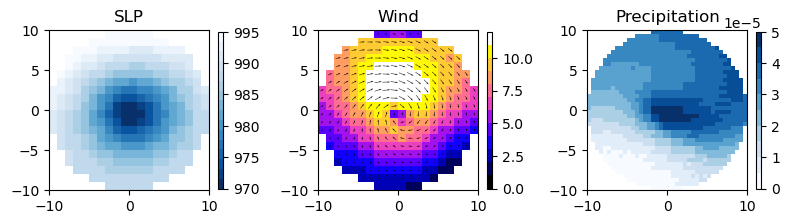

In [40]:
fig, axs = plt.subplots(figsize=(8,4), nrows=1, ncols=3)
axs=axs.flatten()
(1e-2*slp_masked).mean(dim="snapshot").plot(y='y', ax=axs[0],
                                            cmap=plt.get_cmap("Blues_r", 16),
                                            vmin=970, vmax=995, extend="neither",
                                            cbar_kwargs = {'fraction': 0.03,
                                                    'aspect': 30,
                                                    'shrink': 0.7,
                                                    'label':''})

((ds_wind_masked.u_ref**2 + ds_wind_masked.v_ref**2)**0.5).plot(ax=axs[1], y='y',
                                                                vmin=0, vmax=12, cmap=plt.get_cmap('gnuplot2', 12),
                                                                extend="neither",
                                                                cbar_kwargs = {'fraction': 0.03,
                                                                               'aspect': 30,
                                                                               'shrink': 0.7,
                                                                               'label':''})
ds_wind_masked.plot.quiver(ax=axs[1], x='x', y='y', u='u_ref', v='v_ref')

(prlq_masked+prsn_masked).mean(dim="snapshot").plot(y='y', ax=axs[2],
                                            cmap=plt.get_cmap("Blues", 10),
                                            vmin=0, vmax=5e-5, extend="neither",
                                            cbar_kwargs = {'fraction': 0.03,
                                                    'aspect': 30,
                                                    'shrink': 0.7,
                                                    'label':''})

titles = ['SLP', 'Wind', 'Precipitation']

for i in np.arange(3):
    axs[i].set_title(titles[i])
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    axs[i].set_aspect(1)
    
plt.tight_layout()
plt.savefig('/work/Katherine.Turner/CM4_storms/analysis_figures/storm_comp_atm.png', format="png",
           dpi=100, bbox_inches="tight")

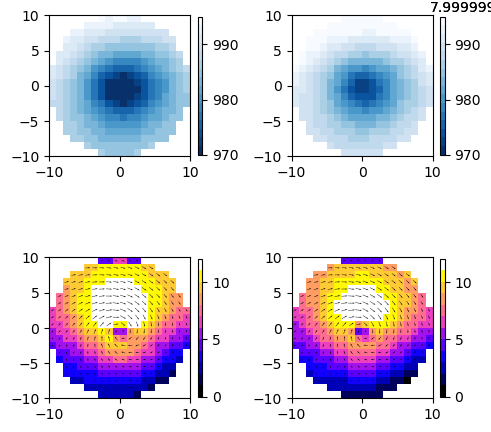

In [31]:
fig, axs = plt.subplots(figsize=(5,5), nrows=2, ncols=2)
axs=axs.flatten()

(1e-2*slp_masked_jja).mean(dim="snapshot").plot(y='y', ax=axs[0],
                                            cmap=plt.get_cmap("Blues_r", 16),
                                            vmin=970, vmax=995, extend="neither",
                                            cbar_kwargs = {'fraction': 0.03,
                                                    'aspect': 30,
                                                    'shrink': 0.7,
                                                    'label':''})

(1e-2*slp_masked_djf).mean(dim="snapshot").plot(y='y', ax=axs[1],
                                            cmap=plt.get_cmap("Blues_r", 16),
                                            vmin=970, vmax=995, extend="neither",
                                            cbar_kwargs = {'fraction': 0.03,
                                                    'aspect': 30,
                                                    'shrink': 0.7,
                                                    'label':''})

((ds_wind_season.u_ref_JJA**2 + ds_wind_season.v_ref_JJA**2)**0.5).plot(ax=axs[2], y='y',
                                                                vmin=0, vmax=12, cmap=plt.get_cmap('gnuplot2', 12),
                                                                extend="neither",
                                                                cbar_kwargs = {'fraction': 0.03,
                                                                               'aspect': 30,
                                                                               'shrink': 0.7,
                                                                               'label':''})
ds_wind_season.plot.quiver(ax=axs[2], x='x', y='y', u='u_ref_JJA', v='v_ref_JJA')

((ds_wind_season.u_ref_DJF**2 + ds_wind_season.v_ref_DJF**2)**0.5).plot(ax=axs[3], y='y',
                                                                vmin=0, vmax=12, cmap=plt.get_cmap('gnuplot2', 12),
                                                                extend="neither",
                                                                cbar_kwargs = {'fraction': 0.03,
                                                                               'aspect': 30,
                                                                               'shrink': 0.7,
                                                                               'label':''})
ds_wind_season.plot.quiver(ax=axs[3], x='x', y='y', u='u_ref_DJF', v='v_ref_DJF')

for i in np.arange(4):
#    axs[i].set_title(titles[i])
    axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    axs[i].set_aspect(1)
    
plt.tight_layout()